In [21]:
from luxai_s2.env import LuxAI_S2
from lux.kit import obs_to_game_state, GameState, EnvConfig
from lux.utils import direction_to, my_turn_to_place_factory
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def interact(env, agents, steps):
    # reset our env
    obs = env.reset(seed=41)
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        done = dones["player_0"] and dones["player_1"]
    return

In [45]:
%load_ext autoreload
%autoreload 2
env = LuxAI_S2() # create the environment object
obs = env.reset(seed=45) # resets an environment with a seed
from agent import Agent
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
#interact(env, agents, 1)

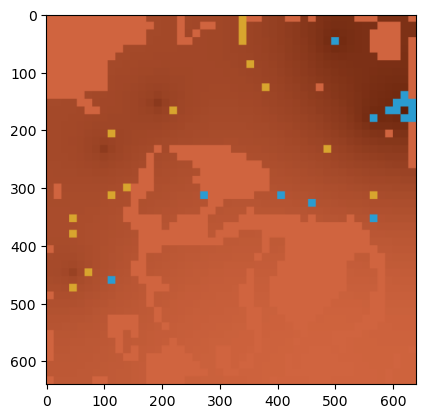

In [46]:
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)

In [47]:
game_state = obs_to_game_state(15, env.state.env_cfg, env.state.get_obs())

In [20]:
closest_ice_tile=np.array([35,40])
closest_factory_tile=np.array([35,42])

In [24]:
 for dx,dy in [[-1,0],[0,1],[1,0],[0,-1]]:
    spot = closest_ice_tile+np.array([dx,dy]) # sum the matricies together to form new spot
    distance_to_fac = np.mean((closest_factory_tile - closest_ice_tile) ** 2)
    if(distance_to_fac<2): # spot is inside the factory borders
      transfer_spot = spot
      break 

In [127]:
zero_rubble_tiles_found=[]




def find_0_rubble(x, y, rubble_board, already_explored, journey_count, limit):
    if journey_count == limit:
        return
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            new_x = x + i 
            new_y = y + j
            if((new_x)<0 or (new_x)>=48 or (new_y)<0 or (new_y)>=48):
                continue 
            if [new_x, new_y] in already_explored or rubble_board[new_x, new_y]!=0 or (new_x==0 and new_y==0) or (new_x==1 and new_y==1) or (new_x==-1 and new_y==-1) or (new_x==1 and new_y==-1) or (new_x==-1 and new_y==1):
                continue 
            else:
                zero_rubble_tiles_found.append((new_x,new_y))
                already_explored.append((new_x,new_y))
                find_0_rubble(new_x, new_y, rubble_board, already_explored, journey_count+1, limit)


In [18]:
def find_zero_rubble_tiles(x, y, rubble_board, explored_tiles=None, zero_rubble_tiles=None): #ChatGPT
    if explored_tiles is None:
        explored_tiles = {}
    if zero_rubble_tiles is None:
        zero_rubble_tiles = {}
    if x < 0 or x >= 48 or y < 0 or y >= 48 or (x, y) in explored_tiles:
        return zero_rubble_tiles
    if rubble_board[x][y] != 0:
        return zero_rubble_tiles
    explored_tiles[(x, y)] = True
    zero_rubble_tiles[(x, y)] = True
    for dx, dy in [[-1, 0], [0, 1], [1, 0], [0, -1]]:
        find_zero_rubble_tiles(x+dx, y+dy, rubble_board, explored_tiles, zero_rubble_tiles)
    return zero_rubble_tiles

In [66]:
def find_zero_rubble_tiles(x, y, rubble_board, orig_x=None, orig_y=None, explored_tiles=None, zero_rubble_tiles=None, factory_tiles=None): #ChatGPT
    print('1')
    if orig_x is None:
        orig_x = x 
    if orig_y is None:
        orig_y = y
    if explored_tiles is None:
        explored_tiles = {}
    if zero_rubble_tiles is None:
        zero_rubble_tiles = {}
    if factory_tiles is None:
        factory_tiles = {}
        for dx in [-1,0,1]:
            for dy in [-1,0,1]:
                factory_tiles[(x + dx, y + dy)] = True

    if x < 0 or x >= 48 or y < 0 or y >= 48 or (x, y) in explored_tiles:
        return zero_rubble_tiles
    if (rubble_board[x][y] != 0) and ((x,y) not in factory_tiles):
        print(factory_tiles)
        print('ran')
        return zero_rubble_tiles
    explored_tiles[(x, y)] = True
    if (x,y) not in factory_tiles:
        zero_rubble_tiles[(x, y)] = True
    for dx, dy in [[-1, 0], [0, 1], [1, 0], [0, -1]]:
        find_zero_rubble_tiles(x+dx, y+dy, rubble_board, orig_x, orig_y, explored_tiles, zero_rubble_tiles, factory_tiles)
    return zero_rubble_tiles

In [67]:
find_zero_rubble_tiles(10,33,game_state.board.rubble)

1
{(19, 65): True, (19, 66): True, (19, 67): True, (20, 65): True, (20, 66): True, (20, 67): True, (21, 65): True, (21, 66): True, (21, 67): True}
ran


{}

In [35]:
zero_rubble_tiles_found = find_zero_rubble_tiles(17, 15, game_state.board.rubble)

In [36]:
zero_rubble_tiles_found

{(17, 15): True,
 (16, 15): True,
 (15, 15): True,
 (14, 15): True,
 (13, 15): True,
 (13, 16): True,
 (14, 16): True,
 (15, 16): True,
 (16, 16): True,
 (17, 16): True,
 (18, 16): True,
 (19, 16): True,
 (20, 16): True,
 (20, 17): True,
 (20, 15): True,
 (19, 15): True,
 (18, 15): True,
 (19, 14): True,
 (20, 14): True,
 (20, 13): True,
 (19, 13): True,
 (19, 12): True,
 (20, 12): True}

In [49]:
zero_rubble_tiles_found=set()
def find_zero_rubble_tiles(x, y, rubble_board, explored_tiles = set(), depth=0, limit=4):
    if depth==limit or x<0 or x>=48 or y<0 or y>=48 or (x,y,) in explored_tiles:
        return
    if(rubble_board[x,y]!=0):
        return
    explored_tiles.add((x,y,))
    zero_rubble_tiles_found.add((x,y,))
    for dx, dy in [[-1,0],[0,1],[1,0],[0,-1]]:
        find_zero_rubble_tiles(x+dx, y+dy, rubble_board, explored_tiles, depth+1, limit)
find_zero_rubble_tiles(17, 15, game_state.board.rubble)
print(zero_rubble_tiles_found)




{(13, 15),
 (13, 16),
 (14, 15),
 (14, 16),
 (15, 15),
 (15, 16),
 (16, 15),
 (16, 16),
 (17, 15),
 (17, 16),
 (18, 15),
 (18, 16),
 (19, 12),
 (19, 13),
 (19, 14),
 (19, 15),
 (19, 16),
 (20, 12),
 (20, 13),
 (20, 14),
 (20, 15),
 (20, 16),
 (20, 17)}

In [9]:
def nothing():
    pass

In [10]:
x=set()
x.add(nothing())
x

{None}

In [129]:
zero_rubble_tiles_found=[]
find_0_rubble(best_tiles[1][0],best_tiles[1][1],rubble_board,already_explored=[],journey_count=0,limit=4)
len(set(zero_rubble_tiles_found))

81

In [120]:
for dx,dy in [[-1,0],[0,1],[1,0],[0,-1]]:
    print(dx)
    print(dy)

-1
0
0
1
1
0
0
-1


In [64]:
rubble_board = game_state.board.rubble == 0

In [98]:
find_0_rubble(20, 15, rubble_board, already_explored=[], journey_count=0, limit=4)


In [131]:
best_tiles = []
most_0_rubble_spots = 0
for fac_tile in best_factory_tiles:
    zero_rubble_tiles_found=[]
    zero_rubble_spots = find_0_rubble(fac_tile[0],fac_tile[1],rubble_board,already_explored=[],journey_count=0,limit=3)
    zero_rubble_spots=len(set(zero_rubble_tiles_found))
    if(zero_rubble_spots > most_0_rubble_spots):
        best_tiles=[fac_tile]
        most_0_rubble_spots=zero_rubble_spots
    elif(zero_rubble_spots==most_0_rubble_spots):
        best_tiles.append(fac_tile)


In [117]:
best_tiles

[(4, 21), (16, 4), (16, 5), (43, 14), (43, 31)]

In [109]:
potential_factory_tiles = list(zip(*np.where(obs['player_0']["board"]["valid_spawns_mask"] == 1)))
smallest_distance = np.inf
best_factory_tiles = []
ice_tiles = np.argwhere(game_state.board.ice==1)
for potential_factory_tile in potential_factory_tiles:
    ice_tile_distances = np.mean((ice_tiles - potential_factory_tile)**2,1)
    closest_ice_distance = np.min(ice_tile_distances)
    #closest_ore_tile = np.argmin(ore_tile_distances) don't actually use these
    #closest_ore_tile_pos = ore_tiles[closest_ore_tile]
    if(closest_ice_distance < smallest_distance):
        smallest_distance = closest_ice_distance
        best_factory_tiles = [potential_factory_tile]
    elif(closest_ice_distance == smallest_distance):
        best_factory_tiles.append(potential_factory_tile)

In [5]:
np.argmin([4,4,4,5,3,2.9,2.9])

5

In [2]:
import numpy as np

In [79]:
def find_adjacent_tiles(gameboard, x, y, characteristic, visited=set()):
    # Base case: if the current tile has already been visited or doesn't have the characteristic,
    # return an empty set
    if (x, y) in visited or gameboard[y][x] != characteristic:
        return set()
    
    # Add the current tile to the visited set
    visited.add((x, y))
    
    # Recursively find all adjacent tiles with the same characteristic
    adjacent_tiles = set()
    if x > 0:
        adjacent_tiles |= find_adjacent_tiles(gameboard, x-1, y, characteristic, visited)
    if y > 0:
        adjacent_tiles |= find_adjacent_tiles(gameboard, x, y-1, characteristic, visited)
    if x < len(gameboard[0]) - 1:
        adjacent_tiles |= find_adjacent_tiles(gameboard, x+1, y, characteristic, visited)
    if y < len(gameboard) - 1:
        adjacent_tiles |= find_adjacent_tiles(gameboard, x, y+1, characteristic, visited)
    
    # Add the current tile to the set of adjacent tiles and return it
    adjacent_tiles.add((x, y))
    return adjacent_tiles

In [80]:
gameboard = [
    ['A', 'B', 'A', 'C'],
    ['B', 'A', 'A', 'B'],
    ['C', 'C', 'A', 'A'],
]

tiles = find_adjacent_tiles(gameboard, 1, 1, 'A')
print(tiles)

{(2, 1), (1, 1), (2, 0), (2, 2), (3, 2)}
